In [1]:
from __future__ import print_function
import numpy as np
from time import time
import pandas as pd

In [3]:
d, N = 1000, 10000 # dimension, number of training points
X = np.random.randn(N, d) # N d-dimensional points
z = np.random.randn(d)

In [4]:
# naively compute square distance between two vector
def dist_pp(z, x):
    d = z - x.reshape(z.shape) # force x and z to have the same dims
    return np.sum(d*d) #this return ||z-X[i]||(2,2)

In [5]:
# from one point to each point in a set, naive
def dist_ps_naive(z, X):
    N = X.shape[0]
    res = np.zeros((1, N))
    for i in range(N):
        res[0][i] = dist_pp(z, X[i])
    return res #this return the vector contain the distance of vector z to each vector in X, just simply a for loop

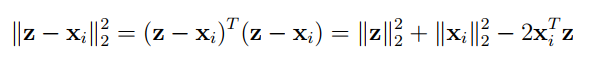

In [6]:
# from one point to each point in a set, fast
def dist_ps_fast(z, X):
    X2 = np.sum(X*X, 1) # square of l2 norm of each X[i], can be precomputed
    z2 = np.sum(z*z) # square of l2 norm of z
    return X2 + z2 - 2*X.dot(z) # z2 can be ignored


In [7]:
t1 = time()
D1 = dist_ps_naive(z, X)
print('naive point2set, running time:', time() - t1, 's')
t1 = time()
D2 = dist_ps_fast(z, X)
print('fast point2set , running time:', time() - t1, 's')
print('Result difference:', np.linalg.norm(D1 - D2))

naive point2set, running time: 0.08177924156188965 s
fast point2set , running time: 0.05130481719970703 s
Result difference: 2.0798167264856508e-11


We can see that the fast approach is 2 time faster than the previous one, because we calculate on a matrix instead of using for loop which is 
0(1) and O(n), the difference in run time between these two aproaches will be even bigger when we train a set of larger observations and data points, let say 1 billion of data points etc.

Now, normally there are a lot of z point to calculate the distance, we see that with each z represented by a vector we have matrix Z to represented the points need to calculate. So we come up with some method to optimize the time:

In [8]:
Z = np.random.randn(100, d)
# from each point in one set to each point in another set, half fast
def dist_ss_0(Z, X):
    M, N = Z.shape[0], X.shape[0]
    res = np.zeros((M, N))
    for i in range(M):
        res[i] = dist_ps_fast(Z[i], X)
    return res

In [9]:
# from each point in one set to each point in another set, fast
def dist_ss_fast(Z, X):
    X2 = np.sum(X*X, 1) # square of l2 norm of each ROW of X
    Z2 = np.sum(Z*Z, 1) # square of l2 norm of each ROW of Z
    return Z2.reshape(-1, 1) + X2.reshape(1, -1) - 2*Z.dot(X.T)


In [10]:
t1 = time()
D3 = dist_ss_0(Z, X)
print('half fast set2set running time:', time() - t1, 's')
t1 = time()
D4 = dist_ss_fast(Z, X)
print('fast set2set running time', time() - t1, 's')
print('Result difference:', np.linalg.norm(D3 - D4))

half fast set2set running time: 5.751626253128052 s
fast set2set running time 0.09264636039733887 s
Result difference: 9.563921693549572e-11


Well, seeing that when we have a lot of z to calculate, the time is about 40 time difference between 2 method, quite alot! 
The after work is for using scikit learn instead of rewrite the algorithm.

Trying with the Iris flower dataset.

In [11]:
from __future__ import print_function
import numpy as np
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.metrics import accuracy_score # for evaluating results

In [16]:
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target
len(iris_X)

150

In [23]:
print('Labels:', np.unique(iris_y))
# split train and test
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=100) #50 for training and 100 for testing
print('Training size:', X_train.shape[0], ', test size:', X_test.shape[0])

Labels: [0 1 2]
Training size: 50 , test size: 100


In [32]:
#build model -> we see that n_neighbors indicate number of nearest neighbor should be chosen, for example n_neighbors=1 we only take 1 neighbor
#the p parameter is for norm, here is l2 norm
model = neighbors.KNeighborsClassifier(n_neighbors = 3, p = 2, weights='distance') #let weights be the distance of data points
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy of 3NN: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy of 3NN: 97.00 %
